# Tracking Demonstration

This notebook applies vehicles [**tracking**](#Apply-Tracking) for **a single 8-minute-video** using [pytorch_objectdetecttrack](https://github.com/cfotache/pytorch_objectdetecttrack) with a few minor modifications (e.g. accelerated renewal of tracking after a frame with no detection), shows various [**properties of the trackings**](#Explanatory-Descriptive-Analysis), studies some [**anomalies**](#Invalid-Trackings-Study) in the trackings (most of them relate to the detection & tracking algorithms rather than actual behavior of vehicles), and studies the [**driving speed**](#Driving-Speed-Analysis) of the cars along the video.

- [**Tracking**](#Apply-Tracking)
- [**Explanatory Descriptive Analysis**](#Explanatory-Descriptive-Analysis)
- [**Anomalies Study**](#Invalid-Trackings-Study)
- [**Driving Speed Analysis**](#Driving-Speed-Analysis)
- [**Summary**](#Summary)

## Configuration

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter, OrderedDict
import cv2
from PIL import Image
from IPython.display import clear_output

In [3]:
import track_tools as tt
clear_output()

In [4]:
mpl.rcParams.update({'font.size': 14})
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

In [5]:
MODE = 'save' # 'load' / 'save' / None
MAX_FRAMES = np.Inf # np.Inf # limit number of frames to read from video
DISPLAY = False # whether to show all frames during the main tracking

AREA = (0, 650, -350, -50) # zone in the frame to focus (x1,x2,y1,y2)
FPS = 30/8 # frames per second in the input video

# Output
OUT_PATH = Path('tracking_demo_data')
OUT_FILE = OUT_PATH/'20190612_175832.slow.pkl' # '20190612_175832.slow.pkl' / 'tmp.pkl'

# Input
DATA = Path(r'D:\Media\Videos\Ayalon') # path of videos
# videopath = str(DATA/'20190622_124116.mp4') # video with very bad detections
# videopath = str(DATA/'20190703_163050_slipping_protest.2.mp4') # video with sparse & fast traffic
videopath = str(DATA/'20190612_175832.mp4') # video with dense & slow traffic

## Apply Tracking

In [6]:
if MODE == 'load':
    
    with open(OUT_FILE,'rb') as f:
        dct = pkl.load(f)
    X = dct['X']
    Y = dct['Y']
    S = dct['S']
    C = dct['C']
    W = dct['W'] if 'W' in dct else AREA[1]-AREA[0]
    H = dct['H'] if 'H' in dct else AREA[3]-AREA[2]
    
else:

    %pylab inline
    X,Y,S,C,other_objs,W,H = tt.analyze_video(videopath, area=AREA, MAX_FRAMES=MAX_FRAMES, DISPLAY=DISPLAY)

Max permitted sequentially-missing frames in tracking: 3
Elapsed time:	50.6 [min]


In [7]:
df, slope = tt.summarize_video(X,Y,S,C,W,H,FPS)
df.head()

d:\code\python\Ayalon\Tracker\track_tools.py:452: RuntimeWarning: invalid value encountered in longlong_scalars
  for car in X.columns]


Data frame shape:
(1211, 27)


,class,n_shots,consistent_class,consistent_xy_nas,continuous_track,avg_size,max_size,valid_size,neg_x_motion,neg_y_motion,...,dt,dx,dy,x_path_rel,y_path_rel,long_path,v,abs_v,road_perpendicularity,perpendicular_range
12,truck,8,True,True,False,102.162959,108.226614,True,0.0,0.000000,...,2.133333,108.5,27.0,0.166923,0.090000,False,52.410464,52.604975,36.403343,8.495548
11,car,40,True,True,True,58.064291,61.911227,True,0.0,0.019417,...,10.400000,337.0,99.0,0.518462,0.330000,True,33.773140,34.461132,27.480755,9.193010
10,car,3,True,True,True,65.790297,67.601775,True,0.0,0.000000,...,0.533333,25.0,10.0,0.038462,0.033333,False,50.485920,50.831730,68.893001,2.638997
9,car,11,True,True,False,55.986974,57.801384,True,0.0,0.000000,...,2.933333,20.5,9.0,0.031538,0.030000,False,7.632482,8.105283,-8.520838,3.287655
8,car,26,True,True,False,60.642076,66.648331,True,0.0,0.005236,...,8.000000,334.5,94.5,0.514615,0.315000,True,43.449054,43.564228,51.906120,9.206764


In [8]:
if MODE == 'save':
    with open(OUT_FILE,'wb') as f:
        pkl.dump({'X':X, 'Y':Y, 'S':S, 'C':C, 'W':W, 'H':H, 'others':other_objs, 'df':df}, f)

In [9]:
gc.collect()

6155

## Explanatory Descriptive Analysis

In [10]:
mpl.rcParams.update({'font.size': 13})

#### Show all trackings

Wall time: 3.35 s


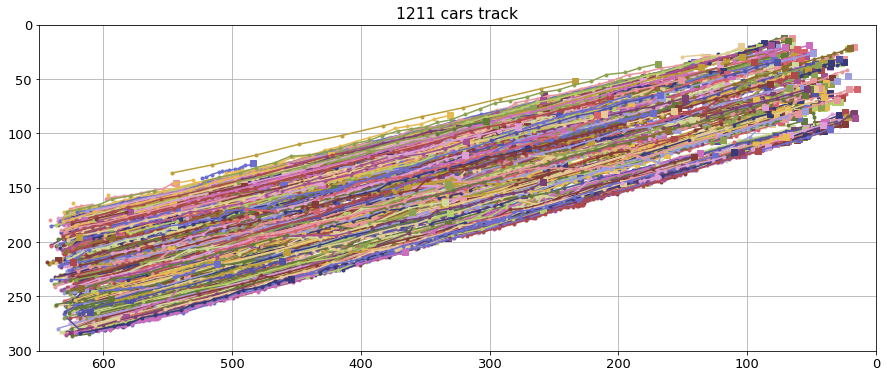

In [11]:
%%time

plt.figure(figsize=(15,6))
plt.title(f'{X.shape[1]:d} cars track')
tt.set_track_figure(W,H)

for car in X.columns:
    tt.plot_track(X,Y,car)

#### Show distributions of data columns

In [12]:
variables_groups_to_compare = (
    ('consistent_class','consistent_xy_nas','valid_size','valid_x_dir','valid_y_dir'),
    ('continuous_track','long_path'),
    ('min_x','max_x'),
    ('min_y','max_y'),
    ('avg_size','max_size'),
    ('v','abs_v'),
)

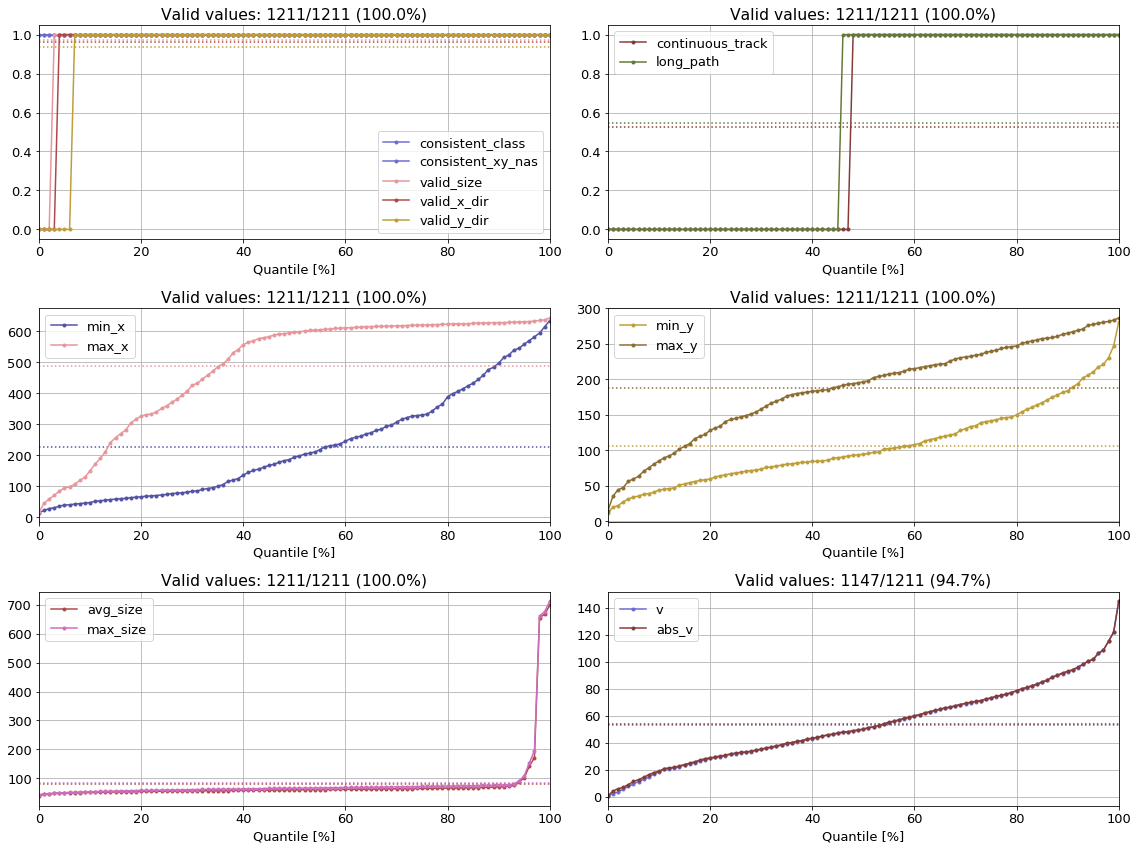

In [13]:
n_rows = int(np.ceil(5/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*4))

for i, cols in enumerate(variables_groups_to_compare):
    ax = plt.subplot(n_rows, 2, i+1)
    tt.qplots(df.loc[:,cols])

plt.tight_layout()

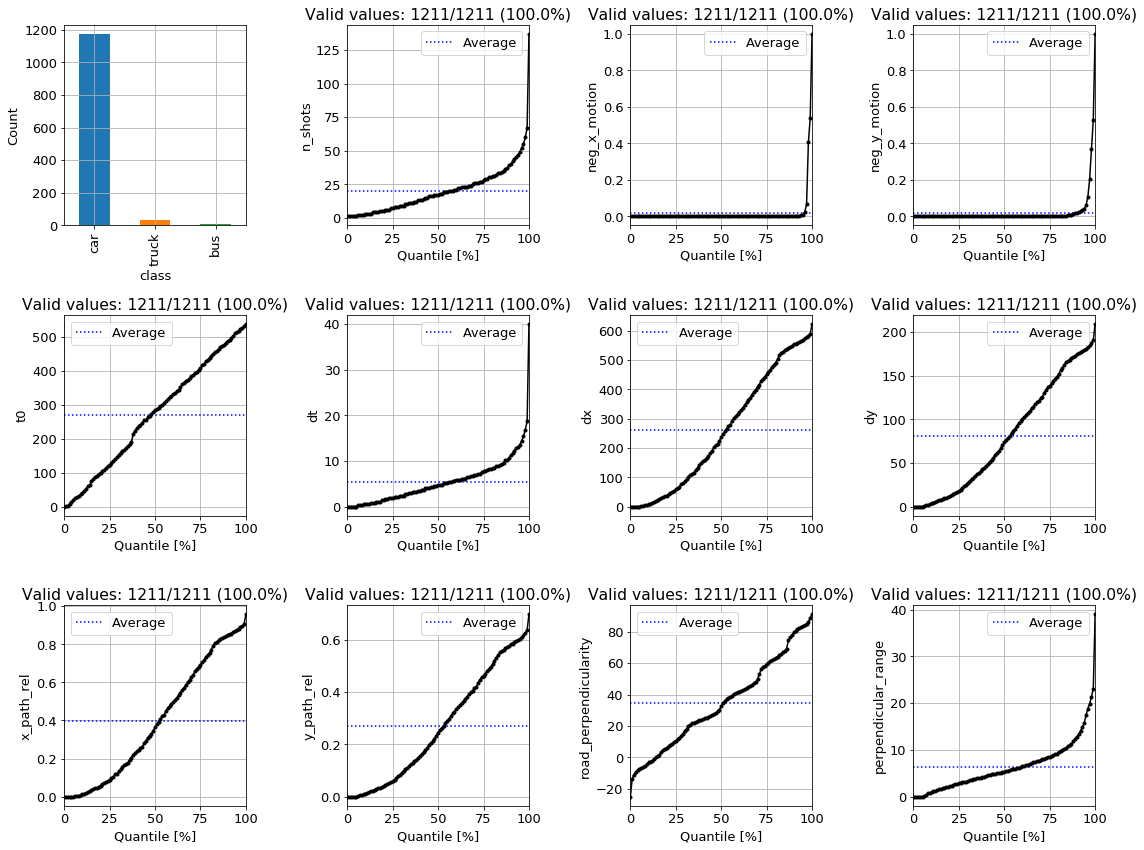

In [14]:
cols = [col for col in df.columns if not col in [c for grp in variables_groups_to_compare for c in grp]]
n_rows = int(np.ceil(len(cols)/4))
_, axs = plt.subplots(n_rows, 4, figsize=(16,n_rows*4))

for i,c in enumerate(cols):
    ax = plt.subplot(n_rows, 4, i+1)
    if type(df[c][0]) is str:
        df[c].value_counts().plot('bar')
        ax.set_xlabel(c)
        ax.set_ylabel('Count')
        ax.grid()
    else:
        tt.qplot(df[c], ax=ax, ylab=c, logscale=False)

plt.tight_layout()

#### Show relations between a few pairs of columns

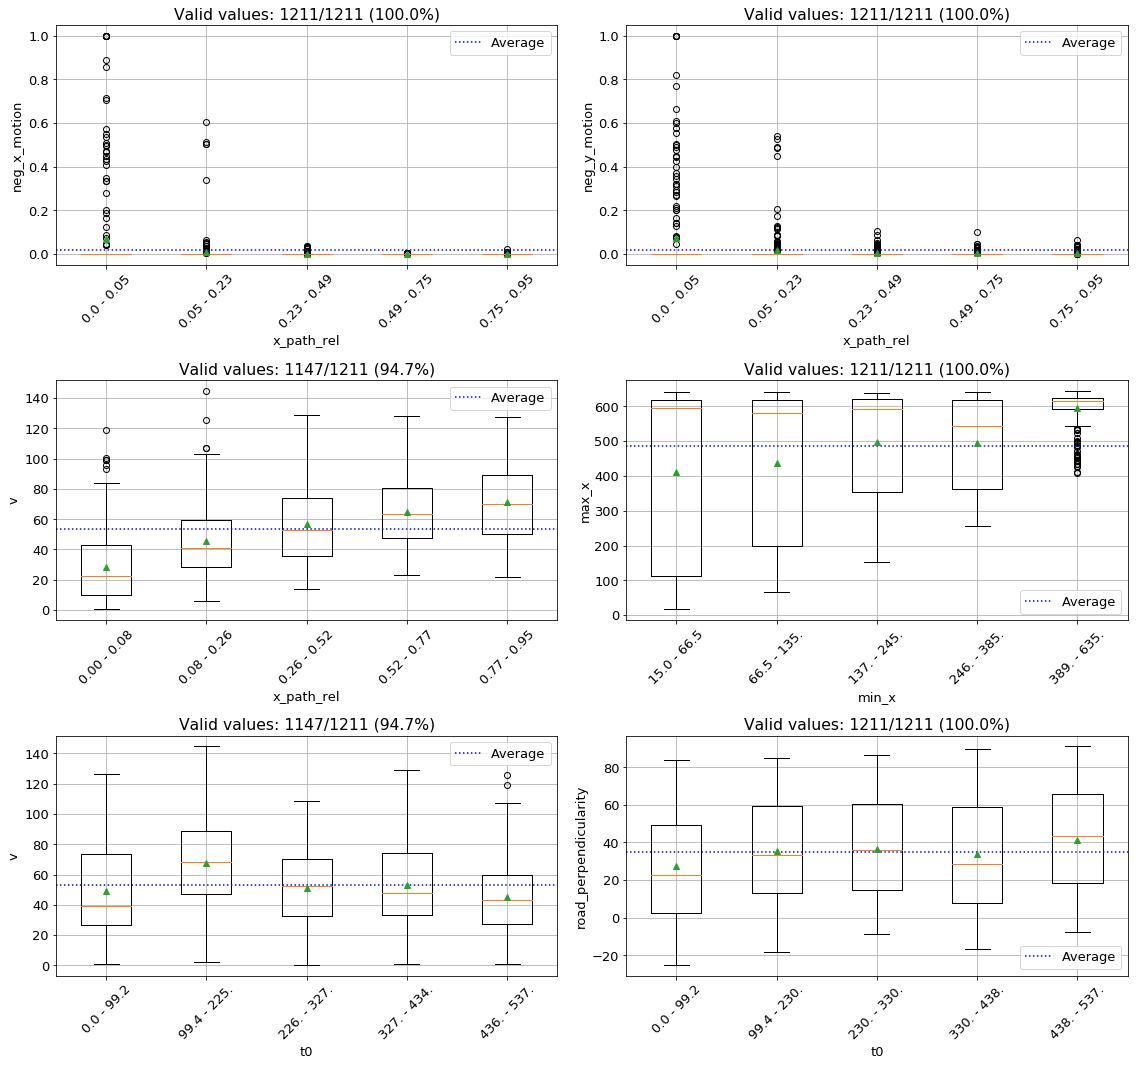

In [15]:
pairs = (
    ('x_path_rel','neg_x_motion'),
    ('x_path_rel','neg_y_motion'),
    ('x_path_rel','v'),
    ('min_x','max_x'),
    ('t0','v'),
    ('t0','road_perpendicularity'),
)

n_rows = int(np.ceil(len(pairs)/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*5))

for i,(c1,c2) in enumerate(pairs):
    ax = plt.subplot(n_rows, 2, i+1)
    tt.boxplot_per_bucket(df[c1], df[c2], ax=ax, xlab=c1, ylab=c2, logscale=False)

plt.tight_layout()

## Invalid Trackings Study

Valid fields:  consistent_class, consistent_xy_nas

valid_x_dir overlaps (all=44):
{'valid_y_dir': 35, 'valid_size': 26, 'long_path': 44, 'continuous_track': 28}

valid_y_dir overlaps (all=78):
{'valid_x_dir': 35, 'valid_size': 25, 'long_path': 66, 'continuous_track': 53}

valid_size overlaps (all=35):
{'valid_x_dir': 26, 'valid_y_dir': 25, 'long_path': 35, 'continuous_track': 21}

long_path overlaps (all=548):
{'valid_x_dir': 44, 'valid_y_dir': 66, 'valid_size': 35, 'continuous_track': 206}

continuous_track overlaps (all=572):
{'valid_x_dir': 28, 'valid_y_dir': 53, 'valid_size': 21, 'long_path': 206}


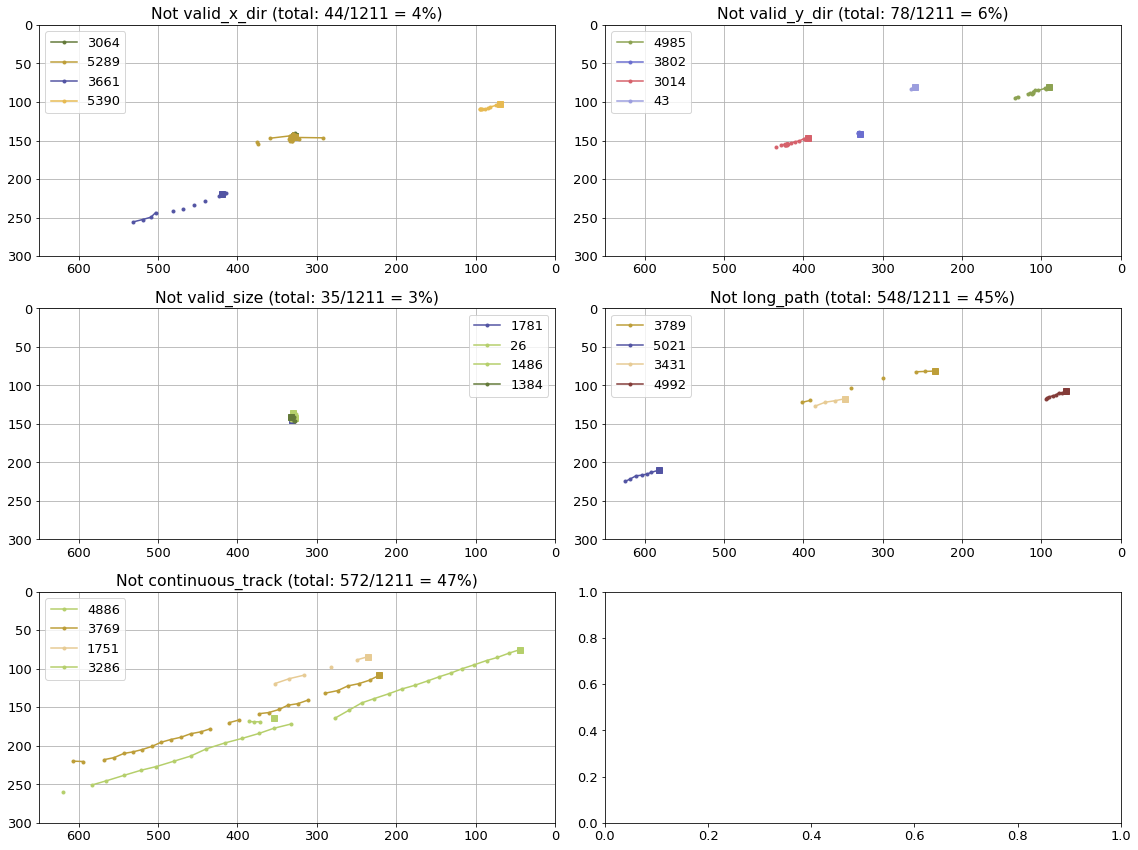

In [16]:
validations = ('consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir','valid_size','long_path','continuous_track')
n_samples = 4

all_valid = [val for val in validations if df[val].all()]
print('Valid fields: ', ', '.join(all_valid))

validations = [val for val in validations if val not in all_valid]
n_rows = int(np.ceil(len(validations)/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*4))

for i,val in enumerate(validations):
    ax = plt.subplot(n_rows, 2, i+1)
    tt.set_track_figure(W,H,ax)
    
    cars = df.index[np.logical_not(df[val])]
    n_bad = len(cars)
    if n_samples < len(cars):
        cars = np.random.choice(cars, n_samples, replace=False)
    
    for car in cars:
        tt.plot_track(X,Y,car,ax)
    ax.set_title(f'Not {val:s} (total: {n_bad:d}/{df.shape[0]:d} = {100*n_bad/df.shape[0]:.0f}%)')
    ax.legend()
    
    print(f'\n{val:s} overlaps (all={np.sum(np.logical_not(df[val])):d}):')
    print({val2: np.sum(np.logical_not(df.loc[np.logical_not(df[val]),val2])) for val2 in validations if val2!=val})

plt.tight_layout()

In [17]:
#assert(False), "Change IDs below and go on"

"Large" cars:

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


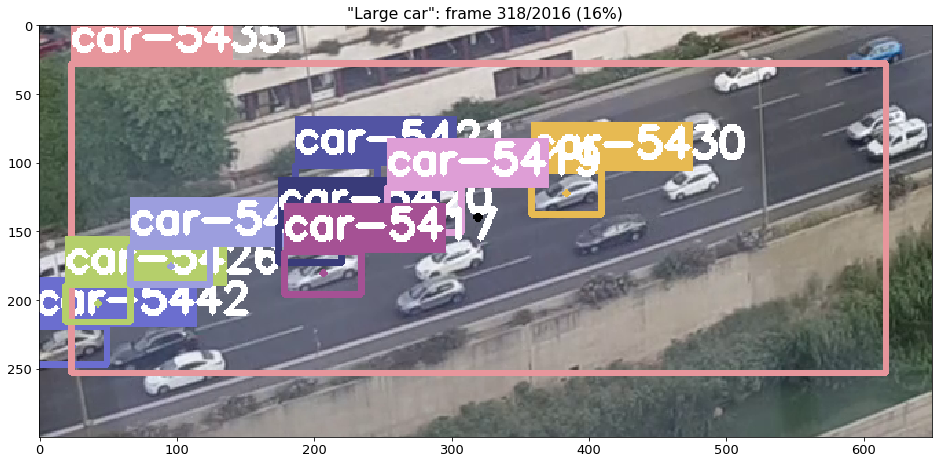

In [18]:
tt.record_frame(videopath, X, Y, '1100', frm=1, self_track=3,
                display=True, boxes=True, to_save=OUT_PATH/'large_car', TITLE='"Large car"')

Negative motion along y-axis:

In [19]:
tt.record_video(videopath, X, Y, '1568', self_track=8, display=False, to_save=OUT_PATH/'neg_y')
clear_output()

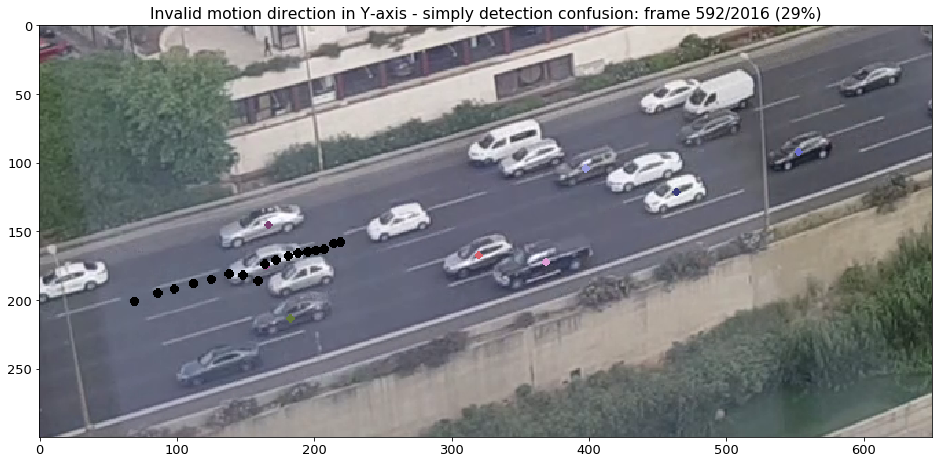

In [20]:
tt.record_frame(videopath, X, Y, '1568', frm=25, self_track=8, display=True, to_save=OUT_PATH/'neg_y',
                TITLE='Invalid motion direction in Y-axis - simply detection confusion')

Motion perpendicular to the road:

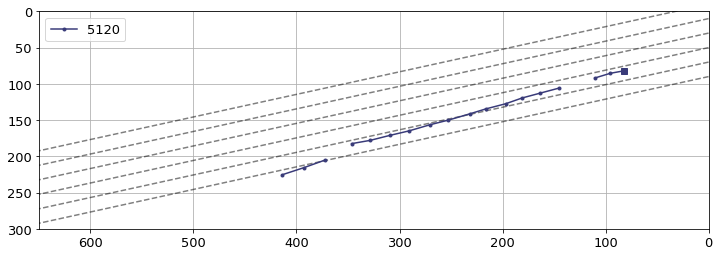

In [21]:
plt.figure(figsize=(12,4))

for i in range(-10,91,20):
    plt.plot(np.linspace(0, W, 100), slope*np.linspace(0, W, 100) + i, 'k--', alpha=0.5)

tt.set_track_figure(W,H)
car = np.random.choice(df.index[df.perpendicular_range>30])
tt.plot_track(X,Y,car)
plt.legend()

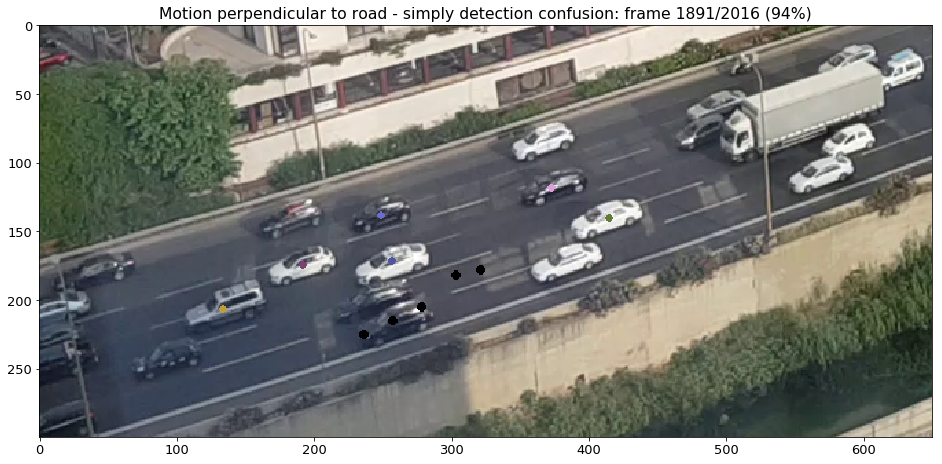

In [22]:
tt.record_frame(videopath, X, Y, '5120', frm=15, self_track=4, display=False, to_save=OUT_PATH/'perp1a')
tt.record_frame(videopath, X, Y, '5120', frm=19, self_track=4, display=True, to_save=OUT_PATH/'perp1b',
               TITLE='Motion perpendicular to road - simply detection confusion')

In [23]:
tt.record_video(videopath, X, Y, '5120', self_track=4, display=False, to_save=OUT_PATH/'perp2')
clear_output()

Short detected paths:

In [ ]:
tt.record_video(videopath, X, Y, '82', self_track=1, extra_frames=30, display=False, to_save=OUT_PATH/'short')
clear_output()

In [ ]:
tt.record_video(videopath, X, Y, '3431', self_track=1, extra_frames=20, display=False, to_save=OUT_PATH/'short_center')

## Driving Speed Analysis

Valid tracks:	651/1211 (54%)


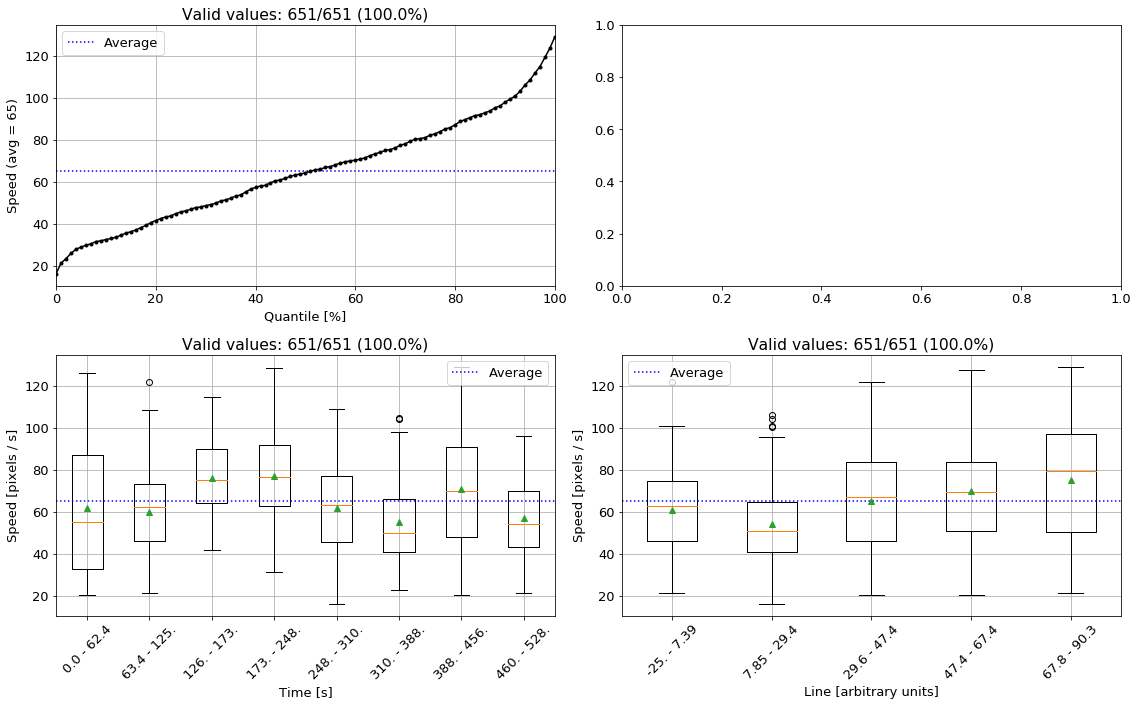

In [25]:
ids = df.loc[:,['consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir',
                'valid_size','long_path']].all(axis=1)

print(f'Valid tracks:\t{ids.sum()}/{len(ids)} ({100*ids.mean():.0f}%)')

_, axs = plt.subplots(2,2, figsize=(16,10))
tt.qplot(df.v[ids], ylab=f'Speed (avg = {df.v[ids].mean():.0f})', ax=axs[0,0])
tt.boxplot_per_bucket(df.t0[ids], df.v[ids], n_buckets=8, xlab='Time [s]', ylab='Speed [pixels / s]', ax=axs[1,0])
tt.boxplot_per_bucket(df.road_perpendicularity[ids], df.v[ids],
                      xlab='Line [arbitrary units]', ylab='Speed [pixels / s]', ax=axs[1,1])
plt.tight_layout()

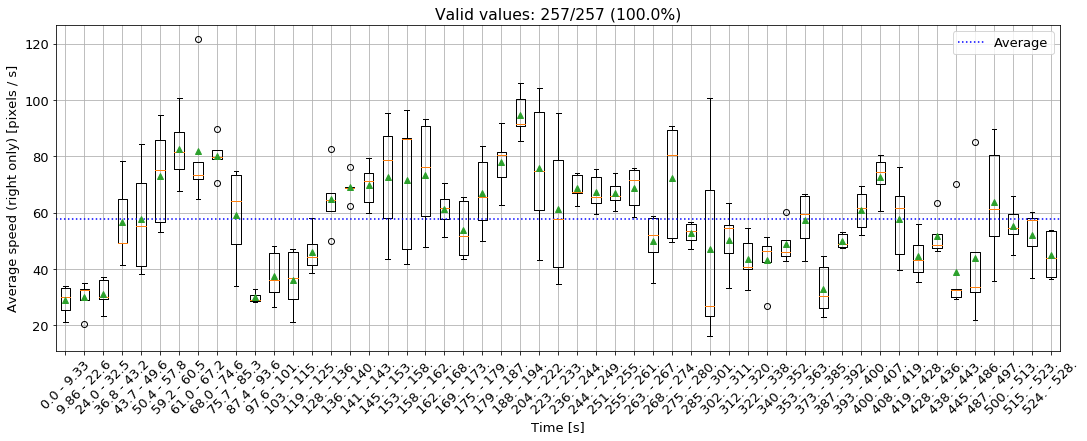

In [26]:
ids = df.loc[:,['consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir',
                'valid_size','long_path']].all(axis=1)
ids = np.logical_and(ids, df.road_perpendicularity<29)

plt.figure(figsize=(18,6))
tt.boxplot_per_bucket(df.t0[ids], df.v[ids], n_buckets=530//10, xlab='Time [s]', ylab='Average speed (right only) [pixels / s]')

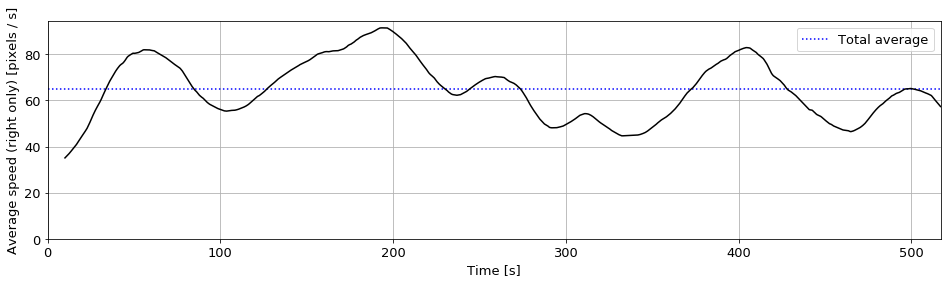

In [46]:
times = list(np.arange(10, df.t0.max()-20, 1/FPS))
decay = 10 # 1/e factor every "decay" seconds
ws = [np.exp(-np.abs(df[ids].t0-t)/decay) for t in times]
rolling_speed = [np.sum(w*df[ids].v)/np.sum(w) for w in ws]

_, axs = plt.subplots(1,1,figsize=(16,4))
ax = axs
ax.axhline(df[ids].v.mean(), color='blue', linestyle=':', label='Total average')
ax.plot(times, rolling_speed, 'k')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Average speed (right only) [pixels / s]')
ax.set_xlim((0,times[-1]))
ax.set_ylim((0,None))
ax.legend()
ax.grid()

In [28]:
ids = df.loc[:,['consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir',
                'valid_size','long_path']].all(axis=1)

fastest = df[ids].v.argmax()
slowest = df[ids].v.argmin()

tt.record_video(videopath, X, Y, fastest, display=False, to_save=OUT_PATH/'fastest')
tt.record_video(videopath, X, Y, slowest, display=False, to_save=OUT_PATH/'slowest')
clear_output()

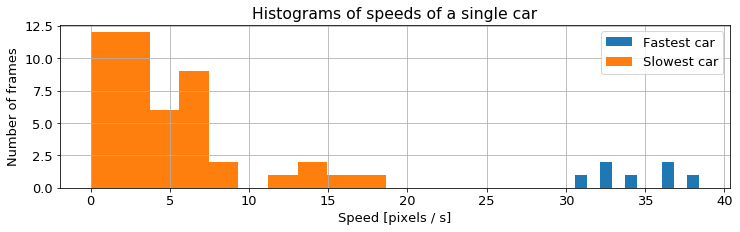

In [29]:
car = fastest
fast_speeds = np.power(np.power(X[car][X[car].notnull()].diff()[1:],2) + np.power(Y[car][Y[car].notnull()].diff()[1:],2), 0.5) /\
              np.diff(np.array(X.index[X[car].notnull()]))

car = slowest
slow_speeds = np.power(np.power(X[car][X[car].notnull()].diff()[1:],2) + np.power(Y[car][Y[car].notnull()].diff()[1:],2), 0.5) /\
              np.diff(np.array(X.index[X[car].notnull()]))

plt.figure(figsize=(12,3))
plt.hist(list(fast_speeds), label='Fastest car')
plt.hist(list(slow_speeds), label='Slowest car')
plt.xlabel('Speed [pixels / s]')
plt.ylabel('Number of frames')
plt.title('Histograms of speeds of a single car')
plt.grid()
plt.legend()
clear_output()

## Summary

### Anomalous trackings

The following phenomena were studied in the tracking data of the video `20190612_175832.mp4`, which produced convenient quality (bright illumination with no significant glass window reflections) and moderately crowded traffic.

| Phenomenon | Estimated frequency | Estimated reasons | Solution |
| --- | --- | --- | --- |
| **Vehicles are not detected** | 40-80% of the vehicles in a frame are not detected | Apparently mainly due to being small and crowded | [**TODO**] Try to decrease the boxes of YOLO? Try to apply some dedicated additional learning somehow? |
| **Very short paths** (< 30% of the observed road) | 50% of tracks | mis-detection for more than a single frame (often due to presence of a street light pole) causes loss of tracking; in addition, few short paths correspond to fake detections | Since the motion is quite predictable and objects cannot disappear behind anything in the middle of a frame, the number of permitted frames without detection was increased from 1 to 3, reducing total tracks from 1410 to 1211 and short paths from 56% to 45%. Further increase of no-detection frames did not help. |
| **Incontinuous track -> missing frames in paths** | 33% of tracks | Few frames are missing due to mis-detections; others are missing because [SORT](https://github.com/abewley/sort) requires several detections in a row before it renews the tracking | Editing SORT code to renew tracking immediately minimized the loss of information due to frames with missing detection. |
| **Very large car size** | 3% of tracks | Fake detection: a whole section of road is classified as "car" | Filtering out vehicles larger than 6 times the median removed the fake detections of this kind. |
| **Motion against road direction** | 4% of tracks | Either fake detections (see "very large car size" above) or short path with nearly-standing motion | Filtering out large cars and short paths solved most of the problem. |
| **Large motion in perpendicular to road** | 2% of tracks | Tracking-confusions (different vehicles are associated with the same object-ID) - and NOT actual line-transitions of cars | The noise model of Kalman filter (```Q```) could be generalized to express smaller uncertainty in the direction perpendicular to the motion; however, since the phenomenon is quite rare, and since improvement of detection is planned anyway, this is out of the scope of the project. Note that by simply filtering these events out, we would give up on detection of line-transitions. |


### Speed analysis

- Speed varies between **lines**. In particular, the rightest line is very slow.
- Speed varies a lot over **time**, without any clear periodicity.